# Chemical-Disease Relation (CDR) Tutorial

In this example, we'll be writing an application to extract *mentions of* **chemical-induced-disease relationships** from Pubmed abstracts, as per the [BioCreative CDR Challenge](http://www.biocreative.org/resources/corpora/biocreative-v-cdr-corpus/).  This tutorial will show off some of the more advanced features of Snorkel, so we'll assume you've followed the Intro tutorial.

Let's start by reloading from the last notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from snorkel import SnorkelSession

session = SnorkelSession()

In [2]:
from snorkel.models import candidate_subclass

ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

train = session.query(ChemicalDisease).filter(ChemicalDisease.split == 0).all()
dev   = session.query(ChemicalDisease).filter(ChemicalDisease.split == 1).all()
test  = session.query(ChemicalDisease).filter(ChemicalDisease.split == 2).all()

print('Training set:\t{0} candidates'.format(len(train)))
print('Dev set:\t{0} candidates'.format(len(dev)))
print('Test set:\t{0} candidates'.format(len(test)))

Training set:	8272 candidates
Dev set:	888 candidates
Test set:	4620 candidates


In [3]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

In [4]:
import torch

In [15]:
from load_external_annotations import load_external_labels
load_external_labels(session, ChemicalDisease, split=0, annotator='gold')
load_external_labels(session, ChemicalDisease, split=2, annotator='gold')

AnnotatorLabels created: 8272
AnnotatorLabels created: 0


In [7]:
from snorkel.annotations import load_gold_labels
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

In [17]:
L_gold_train = load_gold_labels(session, annotator_name='gold', split=0)
print L_gold_train.shape

(8272, 1)


# Part V: Training an LSTM extraction model

In the intro tutorial, we automatically featurized the candidates and trained a linear model over these features. Here, we'll train a more complicated model for relation extraction: an LSTM network. You can read more about LSTMs [here](https://en.wikipedia.org/wiki/Long_short-term_memory) or [here](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). An LSTM is a type of recurrent neural network and automatically generates a numerical representation for the candidate based on the sentence text, so no need for featurizing explicitly as in the intro tutorial. LSTMs take longer to train, and Snorkel doesn't currently support hyperparameter searches for them. We'll train a single model here, but feel free to try out other parameter sets. Just make sure to use the development set - and not the test set - for model selection.

**Note: Again, training for more epochs than below will greatly improve performance- try it out!**

In [31]:
import tensorflow as tf
from snorkel.annotations import load_marginals
from snorkel.learning import reRNN

use_training_labels = True

if use_training_labels:
    train_marginals = [0 if L_gold_train[i,0] <= 0 else 1 for i in range(L_gold_train.shape[0])]
    pos,neg = train_marginals.count(1),train_marginals.count(0)
    print pos,neg, "{:2.1f}%".format(1.0 * pos/(pos+neg) * 100)
    train_marginals = np.array(train_marginals)
else:
    train_marginals = load_marginals(session, split=0)

supervision = "supervised" if use_training_labels else "dp"

3108 5164 37.6%


In [32]:
train_model = True
if train_model:
    train_kwargs = {
        'lr':         0.01,
        'dim':        100,
        'n_epochs':   25,
        'dropout':    0.5,
        'rebalance':  0.0,
        'print_freq': 5
    }

    lstm = reRNN(seed=123, n_threads=None)
    lstm.train(train, train_marginals, X_dev=dev, Y_dev=L_gold_dev, **train_kwargs)
    
else:
    lstm = reRNN(seed=123, n_threads=None)
    lstm.load("lstm.cdr.epochs25.seed123.model")

[reRNN] Training model
[reRNN] n_train=8272  #epochs=25  batch size=256
[reRNN] Epoch 0 (42.69s)	Average loss=0.620956	Dev F1=44.97
[reRNN] Epoch 5 (275.15s)	Average loss=0.145178	Dev F1=56.56
[reRNN] Epoch 10 (521.23s)	Average loss=0.046043	Dev F1=59.22
[reRNN] Epoch 15 (788.60s)	Average loss=0.019937	Dev F1=58.06
[reRNN] Epoch 20 (1062.21s)	Average loss=0.023450	Dev F1=58.16
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 24 (1308.89s)	Average loss=0.034843	Dev F1=56.35
[reRNN] Training done (1310.89s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-20
[reRNN] Loaded model <reRNN>


IOError: [Errno 2] No such file or directory: 'checkpoints/lstm.cdr.supervised.epochs25.seed123.model/model_kwargs.pkl'

In [33]:
lstm.save("lstm.cdr.supervised.epochs25.seed123.model")

[reRNN] Model saved as <lstm.cdr.supervised.epochs25.seed123.model>


In [75]:
lstm.score(test, L_gold_test, b=0.50)

(0.50423280423280425, 0.63322259136212622, 0.5614138438880707)

In [35]:
test_cands = []
for c,l in zip(test, L_gold_test):
    sent_id = (c[0].sentence.document.name, c[0].sentence.position)
    test_cands.append([sent_id, c, l[0,0]])
    
test_cands = sorted(test_cands, key=lambda x:x[0], reverse=0)
_, test_cands, test_gold = zip(*test_cands)

In [45]:
def norm(X):
    X /= np.sqrt((X ** 2).sum(-1))[..., np.newaxis]
    return X

def gramian_matrix(X):
    X /= np.sqrt((X ** 2).sum(-1))[..., np.newaxis] # normalize
    return X.dot(X.T)

In [54]:
X_lstm_emb  = lstm.embed(test_cands)
G_lstm      = gramian_matrix(X_lstm_emb)

In [ ]:
# X_pca_emb   = pca.embed(test_cands).numpy()
# G_pca       = gramian_matrix(X_pca_emb)

In [55]:
# print G_lstm[10,10]
# print G_pca[10,10]

# G_diffs = G_lstm - G_pca


1.0
0.0


In [56]:
# # subsample Gramian 
# n = 100000
# idxs = np.array((np.random.choice(G_diffs.shape[0], n , replace=False),
#                 np.random.choice(G_diffs.shape[0], n , replace=False)))

# sns.distplot(np.ravel(G_diffs)[idxs])

In [ ]:
# def similarity(S, candidates, top_k=10):
    
#     rows, cols = (np.where(np.logical_and(S > -0.01, S < 0.01) ))

#     sim = [(abs(S[i,j]), candidates[i], candidates[j]) for i,j in zip(rows,cols) if i != j]
#     sim = sorted(sim, reverse=1)
#     for i,(s,c1,c2) in enumerate(sim):
#         print s
#         display_candidate(c1)
#         display_candidate(c2)
#         print "---"
#         if i > 10:
#             break
        
    

# similarity(G_diffs, test_cands)

In [ ]:
# import scipy.spatial as sp, scipy.cluster.hierarchy as hc
# linkage = hc.linkage(norm_s_gram)

# sns.clustermap(norm_s_gram, row_linkage=linkage, col_linkage=linkage) 

In [ ]:
# import scipy.spatial as sp, scipy.cluster.hierarchy as hc
# linkage = hc.linkage(s_emb)

# sns.clustermap(s_emb, row_linkage=linkage, col_linkage=linkage) 

In [ ]:
# from viz import *

# for i in range(5):
#     scores = zip(gram[i,...], range(len(gram[i,...])))
#     scores = sorted(scores, reverse=1)
#     display_candidate(test_cands[i], L_gold_test[i,0])
#     print "-"* 50
#     for _,j in scores[1:6]:
#         display_candidate(test_cands[j], L_gold_test[j,0])
#     print "="* 50


## t-SNE Scatter Plots

In [39]:
# We import sklearn.
import sklearn
from sklearn.manifold import TSNE

import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [67]:
tsne_proj = TSNE(n_components=2, perplexity=100, angle=0.5, 
                 n_iter=5000, random_state=123, n_iter_without_progress=1000,
                 learning_rate=500, verbose=True).fit_transform(X_lstm_emb) 

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 4620
[t-SNE] Computed conditional probabilities for sample 2000 / 4620
[t-SNE] Computed conditional probabilities for sample 3000 / 4620
[t-SNE] Computed conditional probabilities for sample 4000 / 4620
[t-SNE] Computed conditional probabilities for sample 4620 / 4620
[t-SNE] Mean sigma: 0.231361
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.936544
[t-SNE] Error after 325 iterations: 0.936544


In [68]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    #palette = np.array(sns.color_palette("hls", 8))
    
    palette = np.array(sns.color_palette("Paired"))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    return f, ax, sc

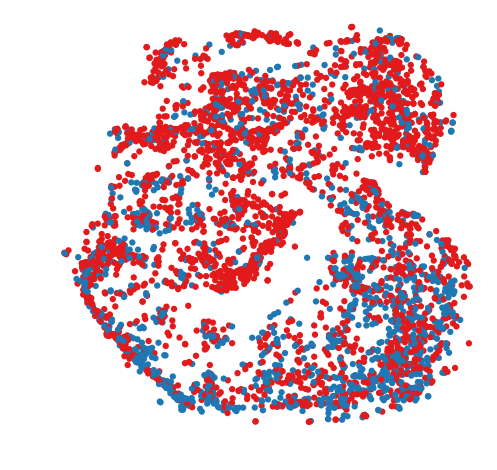

In [69]:
scatter(tsne_proj, np.array(test_gold))
plt.savefig('/users/fries/desktop/cdr-true-labels.png', dpi=120)

In [70]:
# what instances do we correctly classify?
test_marginals = lstm.marginals(test_cands)

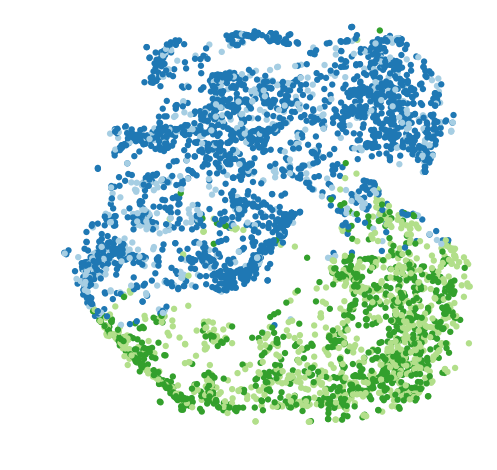

In [71]:
threshold = 0.6
correct = []
for i in range(len(test_marginals)):
    # tn (blue)
    if test_marginals[i] < threshold and test_gold[i] == -1:
        correct.append(1)
    # tp (green)
    elif test_marginals[i] > threshold and test_gold[i] == 1:
        correct.append(3) 
    # fn (light blue)
    elif test_marginals[i] < threshold and test_gold[i] == 1:
        correct.append(0)
    # fp (light green)
    else:
        correct.append(2)
        
scatter(tsne_proj, np.array(correct))
plt.savefig('/users/fries/desktop/cdr-pred-labels.png', dpi=120)

# Part VI: Training an PCA extraction model

In [72]:
from snorkel.contrib.pca import PCA

train_kwargs = {
    'lr':             0.001,
    'word_emb_dim':   300,
    'char_emb_dim':   300,
    'n_epochs':       200,
    'r':              1,
    'batch_size':     100,
    'window_size':    1,
    'asymmetric':     False,
    'word_emb_path':  '/users/fries/desktop/embeddings/medline_pubmed.word.1gram.d300.win30.min5.epoch5.alpha0.05.sample0.0001.txt',
    'char_emb_path':  '/users/fries/desktop/embeddings/glove.840B.300d-char.txt'
}

X_train = train
Y_train = train_marginals
X_dev   = dev
Y_dev   = L_gold_dev

In [73]:
pca = PCA(seed=123, n_threads=None)
pca.train(X_train, Y_train, X_dev=X_dev, Y_dev=Y_dev, **train_kwargs)

Number of learning epochs:      200
Learning rate:                  0.001
Number of principal components: 1
Batch size:                     100
Rebalance:                      False
Surrounding window size:        1
Word embedding size:            300
Char embedding size:            300
Word embedding:                 /users/fries/desktop/embeddings/medline_pubmed.word.1gram.d300.win30.min5.epoch5.alpha0.05.sample0.0001.txt
Char embedding:                 /users/fries/desktop/embeddings/glove.840B.300d-char.txt
Done loading embeddings...
[PCA] n_train= 8272
[PCA] Epoch 5, Training error: 0.572229630251
[PCA] Epoch 10, Training error: 0.537890162182
[PCA] Epoch 15, Training error: 0.516643366915
[PCA] Epoch 20, Training error: 0.501024071437
[PCA] Epoch 25, Training error: 0.488605089759
[PCA] Epoch 30, Training error: 0.478284607542
[PCA] Epoch 35, Training error: 0.469458231843
[PCA] Epoch 40, Training error: 0.461753401581
[PCA] Epoch 45, Training error: 0.454922416916
[PCA] Epoch 50

In [77]:
p, r, f1 = pca.score(X_dev, Y_dev, b=0.5)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

p, r, f1 = pca.score(test, L_gold_test, b=0.5)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.567, Recall: 0.611, F1 Score: 0.589
Prec: 0.565, Recall: 0.645, F1 Score: 0.602


In [216]:
pca_emb = pca.embed(test_cands)
pca_emb.shape

(4620, 4800)

In [217]:
w = pca.model.linear.weight.data.numpy()
w /= np.linalg.norm(w)

In [238]:
tsne_proj = TSNE(n_components=2, perplexity=100, angle=0.2,
                 n_iter=5000, random_state=123, n_iter_without_progress=1000,
                 learning_rate=1000, verbose=True).fit_transform(pca_emb / w) 

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 4620
[t-SNE] Computed conditional probabilities for sample 2000 / 4620
[t-SNE] Computed conditional probabilities for sample 3000 / 4620
[t-SNE] Computed conditional probabilities for sample 4000 / 4620
[t-SNE] Computed conditional probabilities for sample 4620 / 4620
[t-SNE] Mean sigma: 1756.367843
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.848967
[t-SNE] Error after 300 iterations: 0.848967


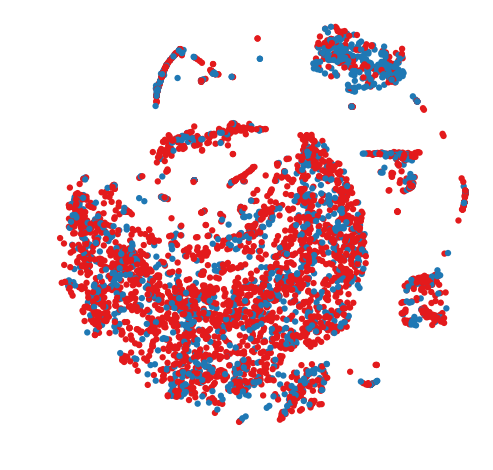

In [239]:
scatter(tsne_proj, np.array(test_gold))
plt.savefig('/users/fries/desktop/cdr-true-labels.png', dpi=120)

In [234]:
test_marginals = pca.marginals(test_cands)

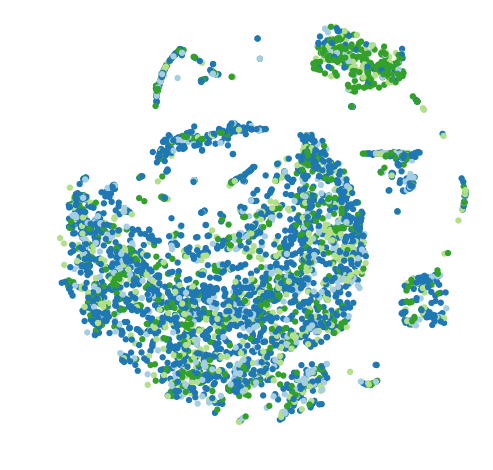

In [240]:
threshold = 0.5
correct = []

for i in range(len(test_marginals)):
    # tn (blue)
    if test_marginals[i] < threshold and test_gold[i] == -1:
        correct.append(1)
    # tp (green)
    elif test_marginals[i] > threshold and test_gold[i] == 1:
        correct.append(3) 
    # fn (light blue)
    elif test_marginals[i] < threshold and test_gold[i] == 1:
        correct.append(0)
    # fp (light green)
    else:
        correct.append(2)
        
scatter(tsne_proj, np.array(correct))
plt.savefig('/users/fries/desktop/cdr-pca-pred-labels.png', dpi=120)

## Gramian Matrices

In [209]:
X_lstm_emb  = lstm.embed(test_cands)
X_pca_emb   = pca.embed(test_cands)

G_lstm      = gramian_matrix(X_lstm_emb)
G_pca       = gramian_matrix(X_pca_emb)

In [210]:
print X_pca_emb.shape
print X_pca_emb[0]

(4620, 4800)
[ 0.01651886 -0.0276206   0.00810914 ..., -0.0132072   0.00526378
  0.00956029]


In [199]:
X_pca_emb *= w
print X_pca_emb[0]

[  1.63047523e+01   8.19895077e+00  -5.26175022e-01 ...,   3.73584199e+00
  -4.44830626e-01   8.47155957e+03]


In [211]:
X_pca_emb /= np.sqrt((X_pca_emb ** 2).sum(-1))[..., np.newaxis]

In [212]:
print X_pca_emb[0]

[ 0.01651886 -0.0276206   0.00810914 ..., -0.0132072   0.00526378
  0.00956029]


In [213]:
G_pca       = gramian_matrix(X_pca_emb)

In [180]:
diffs = G_lstm - G_pca

In [181]:
# print np.linalg.norm(X_lstm_emb[0])
# print np.linalg.norm(X_pca_emb[0])

In [214]:
def print_matrix_stats(M, name="Summary"):
    print "=" * 30
    print "{}".format(name)
    print "=" * 30
    print "median: ",np.median(np.ravel(M))
    print "mean:   ",np.mean(np.ravel(M))
    print "min:    ",np.min(np.ravel(M))
    print "max:    ",np.max(np.ravel(M))

print_matrix_stats(G_lstm, "Gramian (LSTM)")
print_matrix_stats(G_pca, "Gramian (PCA)")
print_matrix_stats(diffs, "Diffs")

Gramian (LSTM)
median:  0.0580037
mean:    0.0942636
min:     -0.792817
max:     1.0
Gramian (PCA)
median:  0.637002
mean:    0.633428
min:     0.147464
max:     1.0
Diffs
median:  -0.574632
mean:    -0.539165
min:     -1.61622
max:     0.70352


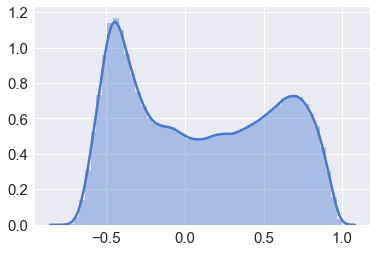

In [174]:
ri = np.random.choice(diffs.shape[0], size=200, replace=False)
rj = np.random.choice(diffs.shape[1], size=200, replace=False)
idx = np.array((ri,rj))

sns.distplot(np.ravel(G_lstm[idx]))

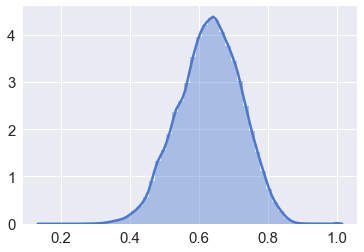

In [215]:
ri = np.random.choice(diffs.shape[0], size=200, replace=False)
rj = np.random.choice(diffs.shape[1], size=200, replace=False)
idx = np.array((ri,rj))

sns.distplot(np.ravel(G_pca[idx]))

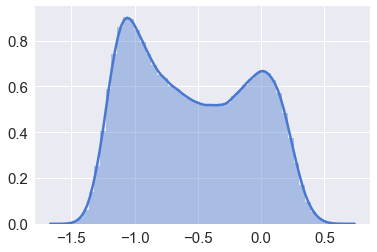

In [176]:
ri = np.random.choice(diffs.shape[0], size=200, replace=False)
rj = np.random.choice(diffs.shape[1], size=200, replace=False)
idx = np.array((ri,rj))

sns.distplot(np.ravel(diffs[idx]))

In [114]:
rows,cols = np.where(diffs < -0.05)
print len(rows)

for i in range(10):
    print i, diffs[i,i]
   

17003936
0 -2.38419e-07
1 0.0
2 1.19209e-07
3 5.96046e-08
4 -1.78814e-07
5 -1.19209e-07
6 5.96046e-08
7 -1.78814e-07
8 -2.38419e-07
9 -2.98023e-07


In [ ]:
#x = diffs[diffs < -0.02]
#rows, cols = (np.where(np.logical_and(diffs > -0.000001,diffs < 0.000001)))

items = [(0,i) for i in range(len(diffs[0])) if diffs[0,i] > -0.00001 and diffs[0,i] < 0.00001] 
print items

display_candidate(test_cands[0])
display_candidate(test_cands[1128])
display_candidate(test_cands[3060])

# #for idx,(i,j) in enumerate(zip(rows,cols)):
#     print i,j, diffs[i,j]
#     display_candidate(test_cands[i])
#     display_candidate(test_cands[j])
#     print gram_lstm[i,j], gram_pca[i,j], gram_lstm[i,j] - gram_pca[i,j]
#     print
#     if idx > 1:
#         break

In [ ]:
def similarity(S, candidates, top_k=10):
    
    i = 0
    ranked = []
    s = np.ravel(S)
    while i < len(s):
        if len(ranked) < top_k:
            ranked.append(s[i])
        elif len(ranked) == top_k and s[i] < max(ranked):
            j = ranked.index(min(ranked))
            ranked[j] = s[i]
        i += 1
    
    print ranked
#     rows, cols = (np.where(S > t))
#     print len(rows)
#     for idx,(i,j) in enumerate(zip(rows,cols)):
#         print i,j, S[i,j]
#         display_candidate(candidates[i])
#         display_candidate(candidates[j])
#         #print gram_lstm[i,j], gram_pca[i,j], gram_lstm[i,j] - gram_pca[i,j]
#         print
#         if idx > top_k:
#             break

In [ ]:
print gram_pca.shape

similarity(gram_pca, test_cands)

In [ ]:
print gram_pca[10,10]
print np.linalg.norm(gram_pca[10])

In [ ]:
trace = [gram_lstm[i,i] for i in range(len(gram_lstm))]

In [ ]:
print trace